---
title-block-banner: true
title: transfer learning tutorial
subtitle: Transfer Learning for Computer Vision Tutorial
description: finetuning에 집중해 코드 위주로 살핀다.
categories:
    - PyTorch
    - computer vision
    - tutorial

toc: false      # 코드 영역때문에 페이지가 답답함
reference-location: document    # callout에서 사용하는 각주가 너무 많다.
---

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# cudnn.benchmark = True
plt.ion()   # 대화형 모드

### 데이터 불러오기

In [2]:
# augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),   # 왜 224?
        transforms.RandomHorizontalFlip(),   # default=0.5
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = "data/hymenoptera_data"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                    data_transforms[x])
                    for x in ['train', 'val']}

batch_size = 8
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                shuffle=True, num_workers=0)
                                                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes 

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

이미지 시각화해서 확인

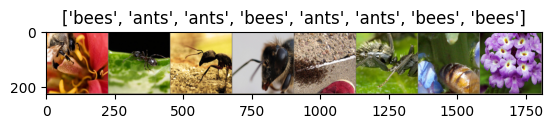

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# 학습 데이터의 배치를 얻고, 매번 다른 배치를 보여준다.
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 학습

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=0):
    since = time.time()

    # 여기서 최고 성능의 모델을 판별하므로 함수 안에서 반복을 해야한다.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 학습
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print('-' * 10)
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

        for phase in ['train', 'val']:  # epoch당 두번 돈다.
            if phase == "train":
                model.train()
            else:
                model.eval()    # 평가모드로 전환
            
            # 먼저 선언
            running_loss = 0.0
            running_corrects = 0

            # 학습/검증 데이터를 가져온다.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 최적화를 위해 경사도를 0으로 선언
                optimizer.zero_grad()

                # forward
                # 학습때만 연산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # 연산 결과
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # 이건 또 뭐야
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            # 원래 .double() 로 데이터형태를 맞춰줬었다.
            # TypeError: Cannot convert a MPS Tensor to float64 dtype 
            # as the MPS framework doesn't support float64. 
            # Please use float32 instead.
            # default 값이 float() 다. 
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            if epoch % 10 == 0:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

### 시각화

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 결과값과 예측값
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### 미세조정

마지막 계층을 초기화하는 단계다.

In [7]:
# 사전학습모델 resnet
# FineTuning의 약자로 ft를 사용하는 것 같음
model_ft = models.resnet18(weights='IMAGENET1K_V1')
# 사전학습모델로부터 fc layer 입력 채널 수를 얻음
num_ftrs = model_ft.fc.in_features  

# 사전학습의 FC layer를 nn.Linear~ 로 교체하는 작업
# 출력 샘플의 크기: ``nn.Linear(num_ftrs, len (class_names))`` 로 일반화
# Linear(in_features=512, out_features=8, bias=True)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# (역전파) 손실함수 지정
criterion = nn.CrossEntropyLoss()

# (최적화) 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft.fc

Linear(in_features=512, out_features=2, bias=True)

In [9]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                         num_epochs=25)

----------
Epoch 0/24
----------
train Loss: 0.5382 Acc: 0.7172
val Loss: 0.2261 Acc: 0.9216
----------
Epoch 10/24
----------
train Loss: 0.1790 Acc: 0.9303
val Loss: 0.1501 Acc: 0.9608
----------
Epoch 20/24
----------
train Loss: 0.1212 Acc: 0.9467
val Loss: 0.1478 Acc: 0.9477

Training complete in 1m 36s
Best val Acc: 0.960784


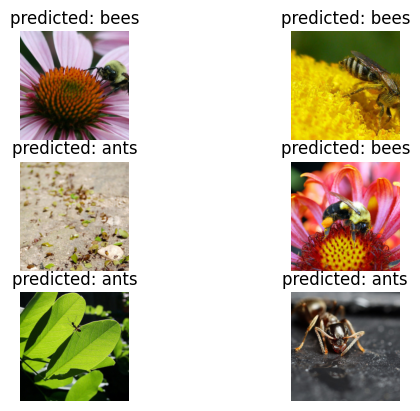

In [10]:
visualize_model(model_ft)